# Лабораторная работа № 2

## Машинное обучение на больших данных с использованием фреймворка Apache Spark и библиотеки SparkML

### Часть 2

В данной части работы рассмотрены:
* подготовка признаков для решения задачи **случайного леса**;
* создание и обучение модели случайного леса;
* оценка качества модели.

#### Запуск `Spark`-сессии

Подключаем необходимые библиотеки.

In [41]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.ml.feature import VectorAssembler, StringIndexer, Binarizer, Bucketizer
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import Window

Сформируем объект конфигурации для Apache Spark, указав необходимые параметры.

In [42]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("Lab 2 Random Forest")
    conf.setMaster("local[*]")
    # conf.set("spark.submit.deployMode", "client")
    # КРИТИЧЕСКИЕ настройки памяти
    conf.set("spark.driver.memory", "8g")          
    conf.set("spark.executor.memory", "6g")        
    conf.set("spark.memory.fraction", "0.8")        
    conf.set("spark.memory.storageFraction", "0.3") 
    
    # Настройки для больших данных
    conf.set("spark.sql.adaptive.enabled", "true")
    conf.set("spark.sql.adaptive.coalescePartitions.enabled", "true")
    conf.set("spark.sql.adaptive.skew.enabled", "true")
    conf.set("spark.sql.shuffle.partitions", "100")  
    
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///b")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

Создаём сам объект конфигурации.

In [43]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию Apache Spark.

In [44]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

Загрузка датасета

In [45]:
df = spark.read.parquet("hdfs://hadoop-namenode:9820/data/mattiev_database/movies_lab1_cleaned")

def print_df(df):
    return df.limit(10).toPandas()

In [46]:
print_df(df)

,asin,reviewerID,reviewerName,reviewText,overall,summary,unixReviewTime,reviewTime
0,B005HS4CUY,A00116683339FAW9XGHO,Mindy Graves,misleading would not play on our DVD player ...,1.0,misleading would not play on our DVD player re...,1490140800,2017-03-22
1,B001J710YS,A0018632VUVKRGSYBEAT,cierra,This product was amazing! It came in record ti...,5.0,Loved This,1353801600,2012-11-25
2,6301753534,A00222906VX8GH7X6J6B,Miguel A. Martinez,good price,5.0,Five Stars,1427846400,2015-01-04
3,B01COCKFOM,A0022400EY2L9WUZ2QRQ,Amazon Customer,I loved it great movie,5.0,Gotta see it,1474588800,2016-09-23
4,B00AEJM61I,A00849873KP522T77IL8,karen stephens,great movie to watch with all the lights of on...,5.0,Five Stars,1443139200,2015-09-25
5,B00EXDW1WA,A01008638Q2KKEWA1SAJ,Karen T.,Hilarious!!!!,5.0,Five Stars,1468540800,2016-07-15
6,0788812467,A0145698H8AAYMRXLBD8,cdy7626,We had this on VHS. Now needed it on DVD. Su...,5.0,Sure its been out a long time (new technology ...,1418515200,2014-12-14
7,B0000E32X3,A0149220O8WD7KG3O5XR,Mike McGrew,All Seasons of Frasier worth watching,5.0,Good solid entertainment,1463788800,2016-05-21
8,B0001NBNJ8,A0149220O8WD7KG3O5XR,Mike McGrew,I think Frasier like fine wine just got better...,5.0,Just gets better,1464566400,2016-05-30
9,B001GCUO5M,A0156038BA2FABM6OVXN,Rob Stidham,One of my all-time favorite movie's. Looks gre...,5.0,RUN,1456185600,2016-02-23


Расшифровка столбцов
| Название столбца  | Расшифровка |
| ------------- | ------------- |
| asin | ID товара  |
|reviewerID  |ID рецензента  |
|reviewerName  |Имя рецензента  |
|reviewText  |Текст отзыва  |
|overall  |Общая оценка  (1.0-5.0)|
|summary  |Краткое описание  |
|unixReviewTime  |Время отзыва в Unix-времени  
| reviewTime | Время отзыва ||

Вспомним схему данных.

In [47]:
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- overall: float (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: integer (nullable = true)
 |-- reviewTime: string (nullable = true)



Вычислим количество строк в датафрейме.

In [48]:
df.count()

6439543

### Постановка задачи
Для датасета, заданного представленными колонками, требуется построить модель Random Forest для оценки факта того, является ли отзыв полезным, по всем остальным признакам.

Для оценки качества обучения следует использовать метрики Precision и Recall. Оценить максимально возможное значение точности при полноте не менее 60%.

### Подготовка и кодирование признаков

In [49]:
from pyspark.sql.functions import year, month, dayofweek, length, when, col, size, split

# Используем ваши признаки
df = df.withColumn("reviewYear", year("reviewTime"))
df = df.withColumn("reviewMonth", month("reviewTime")) 
df = df.withColumn("reviewDayOfWeek", dayofweek("reviewTime"))

# Добавим длину текста отзыва и summary
df = df.withColumn("reviewTextLength", length("reviewText"))
df = df.withColumn("summaryLength", length("summary"))

# Создадим бинарные признаки
df = df.withColumn("isLongReview", when(col("reviewTextLength") > 100, 1).otherwise(0))
df = df.withColumn("isDetailedSummary", when(col("summaryLength") > 10, 1).otherwise(0))

# Создадим целевую переменную (полезный отзыв = оценка 4 или 5)
df = df.withColumn("is_helpful", when(col("overall") >= 4, 1).otherwise(0))

# Дополнительные признаки на основе вашего подхода
df = df.withColumn("reviewWordCount", size(split(col("reviewText"), " ")))
df = df.withColumn("hasLongReview", when(col("reviewTextLength") > 500, 1).otherwise(0))

Анализ признаков

In [50]:
# Проверим корреляцию признаков с целевой переменной
print("Корреляция признаков с целевой переменной:")
correlation_check = df.select(
    F.corr("overall", "is_helpful").alias("corr_overall"),
    F.corr("reviewTextLength", "is_helpful").alias("corr_text_length"),
    F.corr("summaryLength", "is_helpful").alias("corr_summary_length"),
    F.corr("reviewWordCount", "is_helpful").alias("corr_word_count")
).collect()[0]

print(f"Overall rating: {correlation_check['corr_overall']:.4f}")
print(f"Review text length: {correlation_check['corr_text_length']:.4f}")
print(f"Summary length: {correlation_check['corr_summary_length']:.4f}")
print(f"Word count: {correlation_check['corr_word_count']:.4f}")

# Статистика по признакам
print("\nСтатистика по числовым признакам:")
df.select("overall", "reviewTextLength", "summaryLength", "reviewWordCount").describe().show()

print("\nРаспределение бинарных признаков:")
df.groupBy("isLongReview").count().show()
df.groupBy("isDetailedSummary").count().show()
df.groupBy("hasLongReview").count().show()

df = df.drop("overall")

Корреляция признаков с целевой переменной:
Overall rating: 0.8986
Review text length: -0.0811
Summary length: -0.0643
Word count: -0.0835

Статистика по числовым признакам:
+-------+------------------+------------------+------------------+-----------------+
|summary|           overall|  reviewTextLength|     summaryLength|  reviewWordCount|
+-------+------------------+------------------+------------------+-----------------+
|  count|           6439543|           6439543|           6439543|          6439543|
|   mean|4.2756305843442615|155.52103511072136| 20.64180579274026|29.13119766418207|
| stddev|1.2005766460497822|204.24283990029093|17.141232915447084|37.97284773950272|
|    min|               1.0|                10|                 1|                1|
|    max|               5.0|             30046|              1139|             5980|
+-------+------------------+------------------+------------------+-----------------+


Распределение бинарных признаков:
+------------+-------+
|is

Также выполнили удаление признака overall, поскольку на основе данного признака была сделана целевая переменная is_helpful. Иначе будет возникать утечка данных, поскольку данный признак уже фактически определяет целевую переменную.

Выполним **стратифицированное** разделение датасета на обучающую и тестовую выборки.

In [51]:
def stratified_train_test_split(data: DataFrame, 
                                label_col: str,
                                ratio: float) -> tuple[DataFrame, DataFrame]:
    """
    Разделяет DataFrame на тренировочный и тестовый наборы с учетом стратификации.

    Args:
        data: Исходный DataFrame.
        label_col: Название столбца с меткой.
        ratio: Пропорция разделения данных.

    Returns:
        tuple[DataFrame, DataFrame]: Кортеж из тренировочного и тестового DataFrame.
    """
    # Проверяем корректность доли разделения
    assert (isinstance(ratio, float) and (0.0 <= ratio <= 1.0))
    
    # Формируем разделение для положительных и отрицательных объектов раздельно
    train_df_pos, test_df_pos = (data
                                 .filter(F.col(label_col) == 1)
                                 .randomSplit([ratio, 1 - ratio]))
    train_df_neg, test_df_neg = (data
                                 .filter(F.col(label_col) == 0)
                                 .randomSplit([ratio, 1 - ratio]))
    
    # Объединяем датафреймы
    return (train_df_pos.union(train_df_neg),
            test_df_pos.union(test_df_neg))

In [52]:
# Используем стандартное случайное разделение вместо стратифицированного, чтобы избежать потенциальных проблем с соединением
train_ratio = 0.8
train_df, test_df = df.randomSplit([train_ratio, 1 - train_ratio], seed=42)

print(f"Размер обучающей выборки: {train_df.count()}")
print(f"Размер тестовой выборки: {test_df.count()}")

# Проверяем баланс в разделенных данных
print("\nБаланс классов в обучающей выборке:")
train_df.groupBy("is_helpful").count().show()

print("Баланс классов в тестовой выборке:")
test_df.groupBy("is_helpful").count().show()

Размер обучающей выборки: 5152249
Размер тестовой выборки: 1287294

Баланс классов в обучающей выборке:
+----------+-------+
|is_helpful|  count|
+----------+-------+
|         1|4176436|
|         0| 975813|
+----------+-------+

Баланс классов в тестовой выборке:
+----------+-------+
|is_helpful|  count|
+----------+-------+
|         1|1043974|
|         0| 243320|
+----------+-------+



Закешируем сформированные датафреймы и проверим их объем.

In [53]:
train_df = train_df.cache()
test_df = test_df.cache()

# print(f"Train dataset size: {train_df.count()}")
# print(f"Test  dataset size: {test_df.count()}")

In [54]:
train_df.groupBy("is_helpful").count().show()

+----------+-------+
|is_helpful|  count|
+----------+-------+
|         1|4176436|
|         0| 975813|
+----------+-------+



Выполним балансировку датасета с помощью oversampling.

In [55]:
def oversample(data: DataFrame, column: str) -> DataFrame:
    # Разделим датафрейм на положительные и отрицательные классы
    pos = data.filter(F.col(column) == 1)
    neg = data.filter(F.col(column) == 0)

    total_pos = pos.count()
    total_neg = neg.count()

    # Если количество отрицательных классов меньше положительных, выполняем oversampling
    if total_neg < total_pos:
        # Вычислим количество необходимых дубликатов
        num_duplicates = total_pos - total_neg

        # Дублируем отрицательные записи
        oversampled_neg = neg.withColumn(
            "dummy",
            F.explode(
                F.array_repeat(F.lit(1),
                               num_duplicates // total_neg + 1)
            )
        ).drop("dummy")

        # Объединяем дублированные отрицательные записи с положительными
        balanced_df = pos.union(oversampled_neg)
    else:
        balanced_df = data

    return balanced_df

In [56]:
train_df = oversample(train_df, column="is_helpful")

Проверим баланс классов в получившемся датасете.

In [57]:
train_df.groupBy("is_helpful").count().show()

# Проверяем баланс классов после oversampling
print("Баланс классов после oversampling:")
train_balance = train_df.groupBy("is_helpful").count().collect()
for row in train_balance:
    print(f"Класс {row['is_helpful']}: {row['count']} записей "
          f"({row['count']/train_df.count()*100:.1f}%)")

+----------+-------+
|is_helpful|  count|
+----------+-------+
|         1|4176436|
|         0|3903252|
+----------+-------+

Баланс классов после oversampling:
Класс 1: 4176436 записей (51.7%)
Класс 0: 3903252 записей (48.3%)


Остальные признаки сгруппируем по их типу:
- Категориальные признаки закодируем с помощью label encoding.
- Бинарные признаки представлены значениями true / false, которые могут быть интерпретированы как единица и нуль. Поэтому, в кодировании не нуждаются.
- Количественные признаки для Random Forest в специальном кодировании не нуждаются.

In [58]:
# Определяем типы признаков для Random Forest
categorical_features = ["reviewDayOfWeek"]  # День недели как категориальный признак
binary_features = [
    "isLongReview", 
    "isDetailedSummary",
    "hasLongReview"
]
numeric_features = [
    "reviewYear", 
    "reviewMonth",
    "reviewTextLength",
    "summaryLength", 
    "reviewWordCount"
]

print(f"Категориальные: {categorical_features}")
print(f"Бинарные: {binary_features}")
print(f"Числовые: {numeric_features}")

Категориальные: ['reviewDayOfWeek']
Бинарные: ['isLongReview', 'isDetailedSummary', 'hasLongReview']
Числовые: ['reviewYear', 'reviewMonth', 'reviewTextLength', 'summaryLength', 'reviewWordCount']


Выведем датасет перед обучением модели

In [59]:
print_df(df)

,asin,reviewerID,reviewerName,reviewText,summary,unixReviewTime,reviewTime,reviewYear,reviewMonth,reviewDayOfWeek,reviewTextLength,summaryLength,isLongReview,isDetailedSummary,is_helpful,reviewWordCount,hasLongReview
0,B005HS4CUY,A00116683339FAW9XGHO,Mindy Graves,misleading would not play on our DVD player ...,misleading would not play on our DVD player re...,1490140800,2017-03-22,2017,3,4,63,53,0,1,0,12,0
1,B001J710YS,A0018632VUVKRGSYBEAT,cierra,This product was amazing! It came in record ti...,Loved This,1353801600,2012-11-25,2012,11,1,144,10,1,0,1,25,0
2,6301753534,A00222906VX8GH7X6J6B,Miguel A. Martinez,good price,Five Stars,1427846400,2015-01-04,2015,1,1,10,10,0,0,1,2,0
3,B01COCKFOM,A0022400EY2L9WUZ2QRQ,Amazon Customer,I loved it great movie,Gotta see it,1474588800,2016-09-23,2016,9,6,22,12,0,1,1,5,0
4,B00AEJM61I,A00849873KP522T77IL8,karen stephens,great movie to watch with all the lights of on...,Five Stars,1443139200,2015-09-25,2015,9,6,69,10,0,0,1,15,0
5,B00EXDW1WA,A01008638Q2KKEWA1SAJ,Karen T.,Hilarious!!!!,Five Stars,1468540800,2016-07-15,2016,7,6,13,10,0,0,1,1,0
6,0788812467,A0145698H8AAYMRXLBD8,cdy7626,We had this on VHS. Now needed it on DVD. Su...,Sure its been out a long time (new technology ...,1418515200,2014-12-14,2014,12,1,205,128,1,1,1,44,0
7,B0000E32X3,A0149220O8WD7KG3O5XR,Mike McGrew,All Seasons of Frasier worth watching,Good solid entertainment,1463788800,2016-05-21,2016,5,7,37,24,0,1,1,6,0
8,B0001NBNJ8,A0149220O8WD7KG3O5XR,Mike McGrew,I think Frasier like fine wine just got better...,Just gets better,1464566400,2016-05-30,2016,5,2,64,16,0,1,1,12,0
9,B001GCUO5M,A0156038BA2FABM6OVXN,Rob Stidham,One of my all-time favorite movie's. Looks gre...,RUN,1456185600,2016-02-23,2016,2,3,122,3,1,0,1,24,0


Создадим конвейер обработки данных, включающий модель градиентного бустинга на деревьях решений.

In [61]:
def create_pipeline(categorical_features: list[str], numeric_features: list[str], 
                    binary_features: list[str], label_col: str, max_depth: int = 10) -> Pipeline:
    
    # Для категориальных признаков используем StringIndexer
    string_indexer = StringIndexer(inputCols=categorical_features,
                                   outputCols=[f"{feature}_index" for feature in categorical_features],
                                   handleInvalid="keep",
                                   stringOrderType="frequencyDesc")
    
    # Объединяем все признаки
    all_features = [f"{feature}_index" for feature in categorical_features] + binary_features + numeric_features
    
    vector_assembler = VectorAssembler(
        inputCols=all_features,
        outputCol="features"
    )

    # Random Forest
    rf_classifier = RandomForestClassifier(
        featuresCol="features",
        labelCol=label_col,
        predictionCol="prediction",
        probabilityCol="probability",
        rawPredictionCol="rawPrediction",
        numTrees=100,
        maxDepth=max_depth,
        maxBins=32,
        minInstancesPerNode=1,
        subsamplingRate=1.0,
        featureSubsetStrategy="auto",
        impurity="gini",
        seed=42
    )

    pipeline = Pipeline(stages=[
        string_indexer, vector_assembler, rf_classifier
    ])

    return pipeline

In [63]:
pipeline = create_pipeline(
    categorical_features=categorical_features,
    numeric_features=numeric_features,
    binary_features=binary_features,
    label_col="is_helpful",
    max_depth=10
)

### Обучение модели

Выполним подбор гиперпараметров модели линейной регрессии с помощью кросс-валидации на сетке.

Создаем сетку параметров для кросс-валидации, получив объект RandomForestClassifier из конвейера.

In [64]:
param_grid = ParamGridBuilder() \
    .addGrid(pipeline.getStages()[-1].maxDepth, [3, 4, 5]) \
    .addGrid(pipeline.getStages()[-1].numTrees, [20, 30, 40]) \
    .addGrid(pipeline.getStages()[-1].subsamplingRate, [0.7, 0.8]) \
    .build()

Создаем экземпляр BinaryClassificationEvaluator для оценки модели.

In [65]:
cv_evaluator = BinaryClassificationEvaluator(
    labelCol="is_helpful",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

Создаем объект CrossValidator.

In [66]:
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=cv_evaluator,
                                 numFolds=3,
                                 parallelism=4)

Обучаем модель конвейера с использованием кросс-валидации.

In [67]:
print("Начинаем обучение Linear Regression с кросс-валидацией...")
cv_model = cross_validator.fit(train_df)
print("Обучение завершено!")

Начинаем обучение Linear Regression с кросс-валидацией...
Обучение завершено!


Выведем параметры лучшей модели, определенной в ходе кросс-валидации.

In [68]:
def get_best_model_params(cv_model: CrossValidatorModel) -> dict[str, any]:
    """
    Получает параметры лучшей модели из объекта CrossValidatorModel.

    Args:
        cv_model: Объект CrossValidatorModel, содержащий лучшую модель.

    Returns:
        Dict[str, any]: Параметры лучшей модели.
    """
    best_model = cv_model.bestModel
    rf_model = best_model.stages[-1]  # RandomForest модель
    
    best_params = {
        "maxDepth": rf_model.getMaxDepth,           # Без скобок!
        "numTrees": rf_model.getNumTrees,           # Без скобок!
        "subsamplingRate": rf_model.getSubsamplingRate,  # Без скобок!
        "featureSubsetStrategy": rf_model.getFeatureSubsetStrategy  # Без скобок!
    }
    return best_params

In [69]:
print("Параметры лучшей модели Random Forest:")
for key, value in get_best_model_params(cv_model=cv_model).items():
    print(f"{key}: {value}")

Параметры лучшей модели Random Forest:
maxDepth: <bound method _DecisionTreeParams.getMaxDepth of RandomForestClassificationModel: uid=RandomForestClassifier_eeb8eb9b9f46, numTrees=40, numClasses=2, numFeatures=9>
numTrees: 40
subsamplingRate: <bound method _TreeEnsembleParams.getSubsamplingRate of RandomForestClassificationModel: uid=RandomForestClassifier_eeb8eb9b9f46, numTrees=40, numClasses=2, numFeatures=9>
featureSubsetStrategy: <bound method _TreeEnsembleParams.getFeatureSubsetStrategy of RandomForestClassificationModel: uid=RandomForestClassifier_eeb8eb9b9f46, numTrees=40, numClasses=2, numFeatures=9>


### Анализ обученной модели

Рассчитаем метрики на тестовом датасете.

In [70]:
# Получаем датасет предсказаний
test_df_predictions = cv_model.transform(test_df)

# Извлекаем список колонок, устанавливаем цену на последнее место
right_columns_order = test_df_predictions.columns
right_columns_order.remove("is_helpful")
right_columns_order.append("is_helpful")

# Изменяем последовательность колонок и выводим датафрейм
test_df_predictions = test_df_predictions.select(*right_columns_order)
print_df(test_df_predictions)

,asin,reviewerID,reviewerName,reviewText,summary,unixReviewTime,reviewTime,reviewYear,reviewMonth,reviewDayOfWeek,...,isLongReview,isDetailedSummary,reviewWordCount,hasLongReview,reviewDayOfWeek_index,features,rawPrediction,probability,prediction,is_helpful
0,0005000009,A33R5SFMQ2PDH4,Connie,Excellent video and I thorougly enjoyed it ve...,Where Jesus Walked,1397433600,2014-04-14,2014,4,2,...,1,1,27,0,2.0,"[2.0, 1.0, 1.0, 0.0, 2014.0, 4.0, 152.0, 18.0,...","[19.63586356507401, 20.36413643492598]","[0.49089658912685036, 0.5091034108731496]",1.0,1
1,0005019281,A18LQQ6KUK9IF6,Klaus2017,Not the best acting. The story is a classic so...,Great story not the best acting.,1387324800,2013-12-18,2013,12,4,...,1,1,34,0,3.0,"[3.0, 1.0, 1.0, 0.0, 2013.0, 12.0, 171.0, 32.0...","[19.93035801129959, 20.06964198870041]","[0.49825895028248973, 0.5017410497175103]",1.0,0
2,0005019281,A1QZKM8M6866I8,Amazon Customer,While Winkler's make up job is dated and not r...,A nice version of Christmas carol - winkler do...,1481241600,2016-09-12,2016,9,2,...,1,1,35,0,2.0,"[2.0, 1.0, 1.0, 0.0, 2016.0, 9.0, 162.0, 59.0,...","[21.574068839824474, 18.42593116017552]","[0.5393517209956119, 0.46064827900438804]",0.0,1
3,0005019281,A1ZIBVOIPBWR3U,Lilacblue,This is one of my fav versions....set during t...,Love this version of Scrooge!,1387497600,2013-12-20,2013,12,6,...,1,1,30,0,1.0,"[1.0, 1.0, 1.0, 0.0, 2013.0, 12.0, 191.0, 29.0...","[19.93780369604686, 20.06219630395314]","[0.4984450924011715, 0.5015549075988285]",1.0,1
4,0005019281,A2K4AUMORPI9GZ,rwish34,Love anything to do with a Christmas carol. He...,aaaaaa! ...no fonz here!!,1425513600,2015-05-03,2015,5,1,...,1,1,30,0,6.0,"[6.0, 1.0, 1.0, 0.0, 2015.0, 5.0, 180.0, 25.0,...","[21.1036901908461, 18.896309809153898]","[0.5275922547711525, 0.47240774522884743]",0.0,1
5,0005019281,A3M3VVNZSO4OEH,francese smith,Great version of a Xmas carol with a more upda...,Refreshing,1420934400,2015-11-01,2015,11,1,...,0,0,11,0,6.0,"[6.0, 0.0, 0.0, 0.0, 2015.0, 11.0, 56.0, 10.0,...","[4.547923326489161, 35.45207667351084]","[0.11369808316222903, 0.8863019168377709]",1.0,1
6,0005092663,A35PMPEBHXAQ2T,J. C. Frazee,"A great video that should be shown in schools,...",Nation Adrift,1128988800,2005-11-10,2005,11,5,...,1,1,20,0,5.0,"[5.0, 1.0, 1.0, 0.0, 2005.0, 11.0, 138.0, 13.0...","[19.59323313308525, 20.406766866914744]","[0.4898308283271313, 0.5101691716728687]",1.0,1
7,0005119367,A1D79P8RIESO8Y,ACJ,This film was expertly directed and brought ou...,Joseph,1295913600,2011-01-25,2011,1,3,...,1,0,24,0,0.0,"[0.0, 1.0, 0.0, 0.0, 2011.0, 1.0, 136.0, 6.0, ...","[20.858676051738914, 19.141323948261086]","[0.5214669012934728, 0.47853309870652716]",0.0,1
8,0005123968,A32D6S3O3ZIZ43,TT,All these Cedarmont Kids DVDs are awesome and ...,Five Stars,1461110400,2016-04-20,2016,4,4,...,0,0,12,0,3.0,"[3.0, 0.0, 0.0, 0.0, 2016.0, 4.0, 65.0, 10.0, ...","[4.104576614721187, 35.89542338527882]","[0.10261441536802965, 0.8973855846319703]",1.0,1
9,0005123968,A3PBHJWPH8AEF7,Ben George,I needed something Christian to keep my 1 year...,Successful!,1311465600,2011-07-24,2011,7,1,...,1,1,91,0,6.0,"[6.0, 1.0, 1.0, 0.0, 2011.0, 7.0, 482.0, 11.0,...","[20.522620816623505, 19.477379183376495]","[0.5130655204155876, 0.4869344795844124]",0.0,1


In [71]:
def evaluate_model(data: DataFrame, 
                   label_col: str) -> dict[str, float]:
    """
    Оценивает модель с использованием метрик точности, полноты и F1-score.

    Args:
        data: DataFrame, содержащий предсказания и фактические метки.
        label_col: Название колонки с меткой.

    Returns:
        dict[str, float]: Словарь с метриками точности, полноты и F1-score.
    """
    # Вычисляем TP, FP, FN
    tp = data.filter((F.col(label_col) == 1) &
                     (F.col("prediction") == 1)).count()
    fp = data.filter((F.col(label_col) == 0) &
                     (F.col("prediction") == 1)).count()
    fn = data.filter((F.col(label_col) == 1) &
                     (F.col("prediction") == 0)).count()
    tn = data.filter((F.col(label_col) == 0) & 
                     (F.col("prediction") == 0)).count()

    # Вычисляем метрики
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * (precision * recall) / (precision + recall)
        if (precision + recall) > 0 else 0)
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # Выводим матрицу ошибок
    print("Матрица ошибок:")
    print(f"TP: {tp}, FP: {fp}")
    print(f"FN: {fn}, TN: {tn}")
    print(f"Всего записей: {data.count()}")
    
    # Возвращаем словарь с метриками
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }

# # Применяем функцию к нашим предсказаниям
# metrics = evaluate_model(test_predictions, "is_helpful")
# print(f"Metrics: {metrics}")

In [72]:
def evaluate_with_different_thresholds(predictions: DataFrame, label_col: str):
    """Оценка модели с разными порогами классификации"""
    print("\nОценка с разными порогами классификации:")
    print("Threshold | Precision | Recall   | F1       | Accuracy")
    print("-" * 55)
    
    for threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
        threshold_predictions = predictions.withColumn(
            "prediction", 
            when(vector_to_array(F.col("probability")).getItem(1) > threshold, 1).otherwise(0)
        )
        
        metrics = evaluate_model(threshold_predictions, label_col)
        print(f"{threshold:8.2f} | {metrics['precision']:8.4f} | {metrics['recall']:8.4f} | "
              f"{metrics['f1']:8.4f} | {metrics['accuracy']:8.4f}")

# Применяем анализ порогов
evaluate_with_different_thresholds(test_df_predictions, "is_helpful")


Оценка с разными порогами классификации:
Threshold | Precision | Recall   | F1       | Accuracy
-------------------------------------------------------
Матрица ошибок:
TP: 1018215, FP: 179291
FN: 25759, TN: 64029
Всего записей: 1287294
    0.30 |   0.8503 |   0.9753 |   0.9085 |   0.8407
Матрица ошибок:
TP: 992180, FP: 166921
FN: 51794, TN: 76399
Всего записей: 1287294
    0.40 |   0.8560 |   0.9504 |   0.9007 |   0.8301
Матрица ошибок:
TP: 518403, FP: 30345
FN: 525571, TN: 212975
Всего записей: 1287294
    0.50 |   0.9447 |   0.4966 |   0.6510 |   0.5682
Матрица ошибок:
TP: 383471, FP: 5019
FN: 660503, TN: 238301
Всего записей: 1287294
    0.60 |   0.9871 |   0.3673 |   0.5354 |   0.4830
Матрица ошибок:
TP: 379604, FP: 4083
FN: 664370, TN: 239237
Всего записей: 1287294
    0.70 |   0.9894 |   0.3636 |   0.5318 |   0.4807


In [73]:
def calculate_auc_roc(model: RandomForestClassificationModel, 
                      test_data: DataFrame,
                      label_col: str) -> float:
    """
    Рассчитывает значение AUC ROC для модели.

    Args:
        model: Обученная модель классификации.
        test_data: Тестовый набор данных.
        label_col: Название столбца с меткой.

    Returns:
        float: Значение AUC ROC.
    """
    # Получаем прогнозы модели
    predictions = model.transform(test_data)

    # Создаем "оценщик" бинарной классификации
    evaluator = BinaryClassificationEvaluator(
        rawPredictionCol="rawPrediction",
        labelCol=label_col
    )

    # Вычисляем AUC ROC
    auc_roc = evaluator.evaluate(predictions)

    return auc_roc

In [74]:
def prepare_metrics_df(predictions: DataFrame, label_col: str) -> DataFrame:
    """
    Подготавливает DataFrame для расчета FPR, TPR и Precision.

    Args:
        predictions: DataFrame с прогнозами модели.
        label_col: Название столбца с меткой.

    Returns:
        DataFrame: DataFrame с рассчитанными столбцами FPR, TPR и Precision.
    """
    # Формируем датафрейм, содержащий результат предсказания,
    # вероятность предсказания и метку
    metrics_df = (
        predictions
        .select(
            vector_to_array(
                F.col("probability")
            ).getItem(1).alias("probability"),
            
            F.col(label_col).alias("label"),
            F.col("prediction").cast("int").alias("prediction")
        )
    )

    # Сортируем датафрейм по значениям вероятности
    metrics_df = metrics_df.orderBy("probability")

    # Рассчитываем количество положительных и отрицательных классов
    pos_count = metrics_df.filter(metrics_df.label == 1).count()
    neg_count = metrics_df.filter(metrics_df.label == 0).count()

    # Рассчитываем значения FPR и TPR
    window = Window.partitionBy().orderBy(F.desc("probability"))
    metrics_df = (
        metrics_df
        .withColumn("FP_cum", 
                    F.sum(F.when(
                        F.col("label") == 0, 1
                    ).otherwise(0)).over(window))
        .withColumn("TP_cum", F.sum(F.col("label")).over(window))
        .withColumn("FPR", F.col("FP_cum") / neg_count)
        .withColumn("TPR", F.col("TP_cum") / pos_count)
        .withColumn("Precision", 
                    F.col("TP_cum") / (F.col("TP_cum") + F.col("FP_cum")))
    )

    return metrics_df

In [75]:
def bucketize_metrics_df(metrics_df: DataFrame, 
                         num_buckets: int = 1000) -> DataFrame:
    """
    Применяет Bucketizer к DataFrame для уменьшения объёма данных, 
    возвращаемых на драйвер.

    Args:
        metrics_df: DataFrame с рассчитанными столбцами FPR, TPR и Precision.
        num_buckets: Количество бакетов.

    Returns:
        DataFrame: Бакетизированный Dataframe.
    """
    # Определяем границы бакетов
    bucketizer = Bucketizer(
        splits=list(np.linspace(0, 1, num_buckets + 1)),
        inputCol="probability",
        outputCol="bucket"
    )

    # Применяем Bucketizer
    metrics_df = bucketizer.setHandleInvalid("error").transform(metrics_df)

    # Формируем одну точку из каждого бакета
    metrics_df = metrics_df.groupBy("bucket").agg(
        F.avg(F.col("probability")).alias("probability"),
        F.avg(F.col("FPR")).alias("FPR"),
        F.avg(F.col("TPR")).alias("TPR"),
        F.avg(F.col("Precision")).alias("Precision")
    )

    return metrics_df

In [76]:
def calculate_metrics(model: RandomForestClassificationModel, 
                      test_data: DataFrame,
                      label_col: str) -> pd.DataFrame:
    """
    Рассчитывает значения FPR, TPR и Precision для построения ROC и PR-кривых.

    Args:
        model: Обученная модель классификации.
        test_data: Тестовый набор данных.
        label_col: Название столбца с меткой.

    Returns:
        tuple[float, pd.DataFrame]: Кортеж из значения AUC ROC и DataFrame 
                                    со значениями FPR, TPR и Precision.
    """
    # Получаем прогнозы модели
    predictions = model.transform(test_data)

    # Подготавливаем DataFrame для расчета FPR, TPR и Precision
    metrics_df = prepare_metrics_df(predictions, label_col)

    # Применяем Bucketizer к DataFrame
    metrics_df = bucketize_metrics_df(metrics_df)

    return metrics_df.toPandas()

In [79]:
def plot_roc_pr_curves(pd_data: pd.DataFrame, 
                       auc_roc: float) -> None:
    """
    Визуализирует ROC и PR-кривые, добавляет на график AUC ROC.

    Args:
        pd_data: Pandas DataFrame, содержащий столбцы 
            "FPR", "TPR", "Precision".
        auc_roc: Значение AUC-ROC.

    Returns:
        None
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Построение ROC-кривой
    sns.lineplot(x="FPR", y="TPR", data=pd_data, ax=axes[0])
    sns.lineplot(x=[0, 1], y=[0, 1], 
                 color="gray", linestyle="--", ax=axes[0])
    axes[0].set_xlabel("False Positive Rate (FPR)")
    axes[0].set_ylabel("True Positive Rate (TPR)")
    axes[0].set_title("ROC Curve")
    axes[0].grid()

    # Добавляем значение AUC-ROC в правом нижнем углу графика
    axes[0].text(0.94, 0.06, f'AUC-ROC: {auc_roc:.2f}', 
                 transform=axes[0].transAxes,
                 fontsize=12, verticalalignment='bottom', 
                 horizontalalignment='right',
                 bbox=dict(facecolor='white', 
                           alpha=0.8), zorder=5)

    # Построение PR-кривой
    sns.lineplot(x="TPR", y="Precision", 
                 data=pd_data, ax=axes[1])
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("PR Curve")
    axes[1].grid()

    plt.tight_layout()
    plt.show()

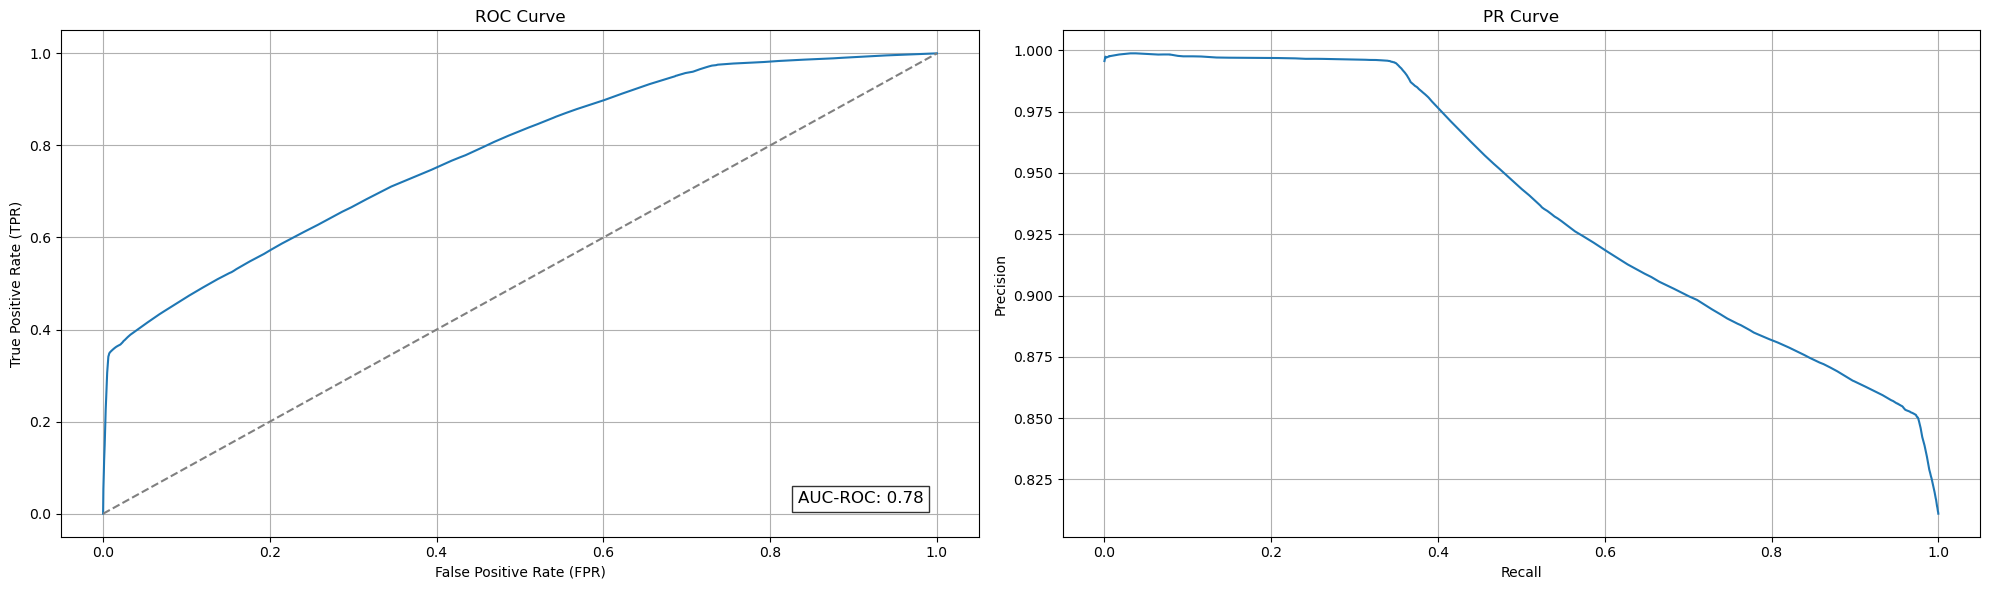

In [80]:
# Рассчитываем AUC ROC
auc_roc = calculate_auc_roc(model=cv_model,
                            test_data=test_df,
                            label_col="is_helpful")
pd_dataframe = calculate_metrics(model=cv_model,
                                 test_data=test_df,
                                 label_col="is_helpful")
plot_roc_pr_curves(pd_dataframe, auc_roc)

Определим вероятность -- границу разделения, при которой Recall не меньше 60%

In [81]:
threshold_probability = pd_dataframe[pd_dataframe['TPR'] >= 0.60]['probability'].max()
print(f"Вероятность -- граница разделения, при которой TPR не меньше 60%: {threshold_probability:.2f}")

Вероятность -- граница разделения, при которой TPR не меньше 60%: 0.48


Рассчитаем метрики на тестовом датасете повторно, с учетом вычисленного threshold для вероятности.

In [82]:
cv_model.bestModel.stages[-1].setThresholds([1 - threshold_probability, 
                                             threshold_probability])
test_df_predictions = cv_model.transform(test_df)
metrics = evaluate_model(test_df_predictions, "is_helpful")
print(f"Metrics: {metrics}")

Матрица ошибок:
TP: 629879, FP: 56347
FN: 414095, TN: 186973
Всего записей: 1287294
Metrics: {'precision': 0.9178885673233017, 'recall': 0.6033474013720648, 'f1': 0.7280996416599237, 'accuracy': 0.6345496832891321}


Не забываем завершать Spark-сессию.

In [40]:
spark.stop()